- [x] Generate default boxes
- [ ] Compute IoU
- [ ] Compute targets
- [ ] Compute Losses: Smooth L1 & Confidence Loss
- [x] SSD Model
- [ ] Init Model with VGG PreTrained
- [ ] Init Model with SSD PreTrained
- [ ] Train step
- [ ] Data Augmentation

# Models

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [2]:
# vgg = VGG16(weights='imagenet', input_shape=(300, 300, 3), include_top=False)

In [3]:
def make_vgg16_layers():
    return [
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1'),
        layers.Conv2D(64, 3, padding='same', activation='relu', name='conv1_2'),
        layers.MaxPool2D(2, 2, padding='same', name='pool1'),

        layers.Conv2D(128, 3, padding='same', activation='relu', name='conv2_1'),
        layers.Conv2D(128, 3, padding='same', activation='relu', name='conv2_2'),
        layers.MaxPool2D(2, 2, padding='same', name='pool2'),

        layers.Conv2D(256, 3, padding='same', activation='relu', name='conv3_1'),
        layers.Conv2D(256, 3, padding='same', activation='relu', name='conv3_2'),
        layers.Conv2D(256, 3, padding='same', activation='relu', name='conv3_3'),
        layers.MaxPool2D(2, 2, padding='same', name='pool3'),

        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv4_1'),
        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv4_2'),
        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv4_3'),
        layers.MaxPool2D(2, 2, padding='same', name='pool4'),

        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv5_1'),
        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv5_2'),
        layers.Conv2D(512, 3, padding='same', activation='relu', name='conv5_3'),

        # different from original vgg16
        # pool5 now has ksize = 3, stride = 1
        layers.MaxPool2D(3, 1, padding='same', name='pool5'),
        # atrous 6-th conv
        layers.Conv2D(1024, 3, padding='same', dilation_rate=6, activation='relu', name='conv6'),
        # 7-th conv
        layers.Conv2D(1024, 1, padding='same', activation='relu', name='conv7'),
    ]

In [4]:
def make_extra_layers():
    return [        
        # 8-th
        layers.Conv2D(256, 1, activation='relu', name='conv8_1'),
        layers.Conv2D(512, 3, strides=2, padding='same', activation='relu', name='conv8_2'),

        # 9-th
        layers.Conv2D(128, 1, activation='relu', name='conv9_1'),
        layers.Conv2D(256, 3, strides=2, padding='same', activation='relu', name='conv9_2'),

        # 10-th
        layers.Conv2D(128, 1, activation='relu', name='conv10_1'),
        layers.Conv2D(256, 3, strides=1, activation='relu', name='conv10_2'),

        # 11-th
        layers.Conv2D(128, 1, activation='relu', name='conv11_1'),
        layers.Conv2D(256, 3, strides=1, activation='relu', name='conv11_2'),
    ]

def make_conf_heads_layers(num_classes):
    return [
        layers.Conv2D(4 * num_classes, 3, padding='same', name='conf_4'), # 4th block - 4 default boxes
        layers.Conv2D(6 * num_classes, 3, padding='same', name='conf_7'), # 7th block - 6 default boxes
        layers.Conv2D(6 * num_classes, 3, padding='same', name='conf_8'), # 8th block - 6 default boxes
        layers.Conv2D(6 * num_classes, 3, padding='same', name='conf_9'), # 9th block - 6 default boxes
        layers.Conv2D(4 * num_classes, 3, padding='same', name='conf_10'), # 10th block - 4 default boxes
        layers.Conv2D(4 * num_classes, 3, padding='same', name='conf_11'), # 11th block - 4 default boxes        
    ]

def make_loc_heads_layers():
    return [
        layers.Conv2D(4 * 4, 3, padding='same', name='loc_4'), # 4th block - 4 default boxes
        layers.Conv2D(6 * 4, 3, padding='same', name='loc_7'), # 7th block - 6 default boxes
        layers.Conv2D(6 * 4, 3, padding='same', name='loc_8'), # 8th block - 6 default boxes
        layers.Conv2D(6 * 4, 3, padding='same', name='loc_9'), # 9th block - 6 default boxes
        layers.Conv2D(4 * 4, 3, padding='same', name='loc_10'), # 10th block - 4 default boxes
        layers.Conv2D(4 * 4, 3, padding='same', name='loc_11'), # 11th block - 4 default boxes        
    ]

In [5]:
class SSD(keras.Model):
    
    def __init__(self, num_classes=20):
        super().__init__()
        
        self.vgg_layers = make_vgg16_layers()
        self.extra_layers = make_extra_layers()
        self.conf_layers = make_conf_heads_layers(num_classes)
        self.loc_layers = make_loc_heads_layers()
        self.out_layers = ["conv4_3", "conv7", "conv8_2", "conv9_2", "conv10_2", "conv11_2"]
        
    def get_conf_loc(self, fm, index):
        conf = self.conf_layers[index](fm)
        loc = self.loc_layers[index](fm)
        return conf, loc

    def call(self, x):
        conf_outputs = []
        loc_outputs = []
        
        head_index = 0
        for layer in self.vgg_layers:
            x = layer(x)
            if layer.name in self.out_layers:
                conf, loc = self.get_conf_loc(x, head_index)
                conf_outputs.append(conf)
                loc_outputs.append(loc)
                head_index += 1
        
        for layer in self.extra_layers:
            x = layer(x)
            if layer.name in self.out_layers:
                conf, loc = self.get_conf_loc(x, head_index)
                conf_outputs.append(conf)
                loc_outputs.append(loc)
                head_index += 1
            
        return conf_outputs, loc_outputs
    
    def model(self):
        inputs = layers.Input(shape=(300, 300, 3), name='input_image')
        model = keras.Model(inputs=inputs, outputs=self.call(inputs))
        return model

In [6]:
m = SSD()

In [7]:
m.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input_image[0][0]                
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 150, 150, 64) 0           conv1_2[0][0]                    
______________________________________________________________________________________________

# Generate anchor boxes

In [8]:
import math
from collections import OrderedDict

def create_anchor_boxes(verbose=False):
    anchors_config = OrderedDict({
        "conv4_3": {
            "size": 38,
            "scale": 0.1,
            "ratios": [1, 2, 0.5],
        },
        "conv7": {
            "size": 19,
            "scale": 0.2,
            "ratios": [1, 2, 0.5, 3, 0.33],
        },
        "conv8_2": {
            "size": 10,
            "scale": 0.375,
            "ratios": [1, 2, 0.5, 3, 0.33],
        },
        "conv9_2": {
            "size": 5,
            "scale": 0.55,
            "ratios": [1, 2, 0.5, 3, 0.33],
        },
        "conv10_2": {
            "size": 3,
            "scale": 0.725,
            "ratios": [1, 2, 0.5],
        },
        "conv11_2": {
            "size": 1,
            "scale": 0.9,
            "ratios": [1, 2, 0.5],
        },
    })
    
    def get_next_scale(current_name):
        def get_scale(name):
            return anchors_config[name]['scale']
        try:
            keys = list(anchors_config.keys())
            current_index = keys.index(current_name)
            next_name = keys[current_index+1]
            next_scale = get_scale(next_name)
        except:
            next_scale = get_scale(current_name)
        return next_scale
    
    def create_anchor(cx, cy, scale, ratio):
        # cx, cy, w, h
        return [cx, cy, scale * math.sqrt(ratio), scale / math.sqrt(ratio)]

    anchors = []

    for name, config in anchors_config.items():
        fm_size = config['size']
        scale = config['scale']
        ratios = config['ratios']
        next_scale = get_next_scale(name)
        
        n_anchors = 0
        for i in range(fm_size):
            for j in range(fm_size):
                cx = (i + 0.5) / fm_size
                cy = (j + 0.5) / fm_size
                for ratio in ratios:
                    anchors.append(create_anchor(cx, cy, scale, ratio))
                    n_anchors += 1
                    # add one extra anchors with ratio of 1 and scale that is the geometric mean of current and next map
                    if ratio == 1:
                        extra_scale = math.sqrt(scale * next_scale)
                        anchors.append(create_anchor(cx, cy, extra_scale, ratio))
                        n_anchors += 1
        if verbose:
            print("feature map =", "{:8s}".format(name), 
                  "# anchors =", "{:5d}".format(n_anchors), 
                  "scale =", "{:.3f}".format(scale), " ratios =", ratios)
    if verbose:
        print("# anchors = ", len(anchors))
    return anchors

In [9]:
anchors = create_anchor_boxes(verbose=True)

feature map = conv4_3  # anchors =  5776 scale = 0.100  ratios = [1, 2, 0.5]
feature map = conv7    # anchors =  2166 scale = 0.200  ratios = [1, 2, 0.5, 3, 0.33]
feature map = conv8_2  # anchors =   600 scale = 0.375  ratios = [1, 2, 0.5, 3, 0.33]
feature map = conv9_2  # anchors =   150 scale = 0.550  ratios = [1, 2, 0.5, 3, 0.33]
feature map = conv10_2 # anchors =    36 scale = 0.725  ratios = [1, 2, 0.5]
feature map = conv11_2 # anchors =     4 scale = 0.900  ratios = [1, 2, 0.5]
# anchors =  8732


# Visualize anchor boxes

In [10]:
%matplotlib inline

In [11]:
import random
from PIL import ImageDraw, Image, ImageFont
from matplotlib import pyplot as plt

def random_colors():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

def draw_anchor(draw, anchor, img_size, label_text=None, font=ImageFont.truetype('arial', size=10)):
    cx, cy, w, h = anchor
    tl = (max(0, (cx - w / 2) * img_size), max(0, (cy - h / 2) * img_size))
    br = (min(img_size - 1, (cx + w / 2) * img_size), min(img_size - 1, (cy + h / 2) * img_size))
    color = random_colors()
    draw.rectangle((tl, br), outline=color, width=2)
    
    if label_text is not None:
        txt_size = draw.textsize(label_text, font=font)
        draw.rectangle((tl, (tl[0] + txt_size[0], tl[1] + txt_size[1])), fill=color)
        draw.text(tl, label_text, font=font)

def visualize_anchor_boxes(anchors, n_anchors=10, image=None, img_size=300, figsize=(5, 5)):
    if image is None:
        image = Image.new('RGB', (img_size, img_size))
    draw = ImageDraw.Draw(image)
    for anchor in random.sample(anchors, k=n_anchors):
        draw_anchor(draw, anchor, img_size)
        
    plt.figure(figsize=figsize)
    plt.imshow(image)

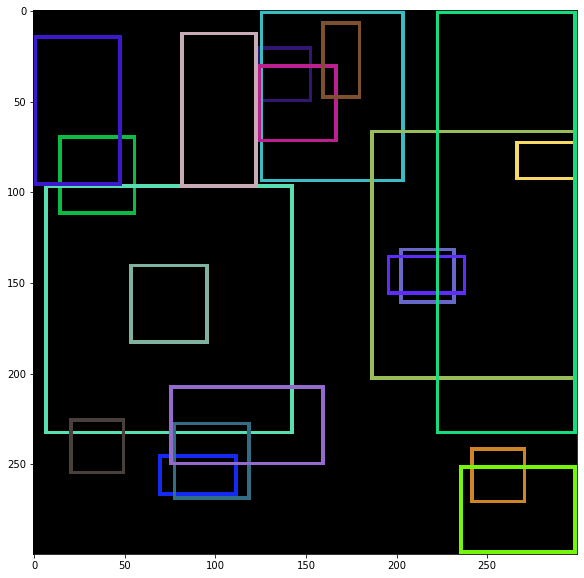

In [12]:
visualize_anchor_boxes(anchors, figsize=(10, 10), n_anchors=20)

# COCO Dataset

In [13]:
import tensorflow as tf

import tensorflow_datasets as tfds
print(tfds.__version__)
tfds.disable_progress_bar()

import pathlib

data_dir = "D:\\Data\\coco\\2017"
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)

1.3.2


In [14]:
datasets, info = tfds.load("coco/2017", data_dir=data_dir, with_info=True)

In [15]:
raw_ds_train = datasets['train']
n_train = info.splits['train'].num_examples
IMG_SIZE = 300

In [16]:
int2str = info.features['objects']['label'].int2str
def index_to_label(index):
    return int2str(index)

In [17]:
def yxyx_to_xyxy(bbox):
    """
    Convert bboxes from TensorFlow BBoxFeature ([ymin, xmin, ymax, xmax]) to boundary coordinate (xmin, ymin, xmax, ymax)
    """
    ymin, xmin, ymax, xmax = bbox
    return (xmin, ymin, xmax, ymax)

In [18]:
@tf.function
def horizontal_flip(image, boxes, labels):
    """ Function to flip the image horizontally
    Args:
        image: image tensor
        boxes: boxes tensor (num_boxes, 4) TensorFlow BBoxFeature (num_boxes, [ymin, xmin, ymax, xmax])
        labels: labels tensor (num_boxes,)

    Returns:
        image: the horizontally flipped PIL Image
        boxes: horizontally flipped boxes tensor (num_boxes, 4)
        labels: labels tensor (num_boxes,)
    """
    image = tf.image.flip_left_right(image)
    boxes = tf.stack([
        boxes[:, 0],
        1 - boxes[:, 3],
        boxes[:, 2],
        1 - boxes[:, 1],
    ], axis=1)
    return image, boxes, labels

@tf.function
def random_horizontal_flip(image, boxes, labels):
    uniform_random = tf.random.uniform([], 0, 1.0)
    mirror_cond = tf.math.less(uniform_random, .5)
    return tf.cond(
          mirror_cond,
          lambda: horizontal_flip(image, boxes, labels),
          lambda: (image, boxes, labels))

In [19]:
@tf.function
def normalize_image(image):
    image = tf.cast(image, tf.float32) / 255.
    return image

@tf.function
def prepare_train_image(data):
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    objects = data['objects']
    bboxes = objects['bbox'] # yxyx
    labels = objects['label']
    
    return normalize_image(image), bboxes, labels

In [20]:
ds_train = raw_ds_train.map(prepare_train_image, tf.data.experimental.AUTOTUNE)\
                       .cache()\
                       .map(random_horizontal_flip, tf.data.experimental.AUTOTUNE)

In [21]:
def draw_object_bbox_xyxy(draw, bbox_xyxy, h, w, label_text, font=ImageFont.truetype('arial', size=15), border_width=5):
    xmin, ymin, xmax, ymax = bbox_xyxy

    tl = (xmin * w, ymin * h)
    br = (xmax * w, ymax * h)
    color = 'red'
    draw.rectangle((tl, br), outline=color, width=border_width)
    
    txt_size = draw.textsize(label_text, font=font)
    draw.rectangle((tl, (tl[0] + txt_size[0], tl[1] + txt_size[1])), fill=color)
    draw.text(tl, label_text, font=font)

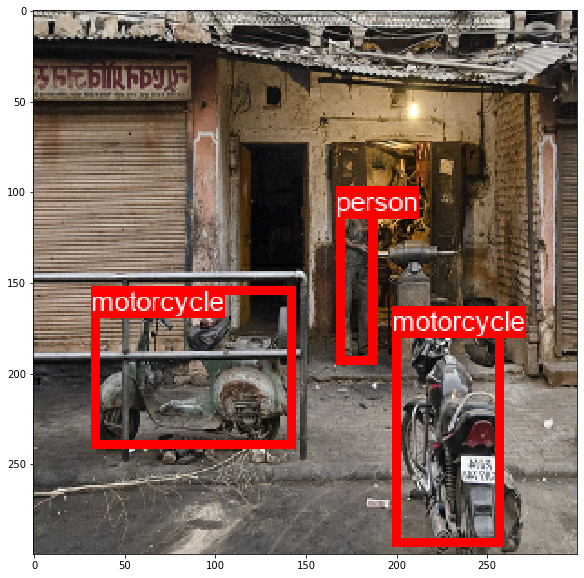

In [22]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

figsize = (10, 10)

for image, bboxes, labels in ds_train.take(1): 
    image = Image.fromarray(np.array(image * 255, dtype=np.uint8))
    
    draw = ImageDraw.Draw(image)
    
    h, w = image.height, image.width
    for bbox, label in zip(bboxes, labels):
        bbox_xyxy = yxyx_to_xyxy(bbox)
        label_text = index_to_label(label)
        
        draw_object_bbox_xyxy(draw, bbox_xyxy, h, w, label_text)
    plt.figure(figsize=figsize)
    plt.imshow(image)

# Compute IoU

In [23]:
def clip_by_value(v, lower, upper):
    return max(lower, min(v, upper))

In [87]:
def compute_iou(anchor_cxcy, bbox_xyxy):
    cx, cy, w, h = anchor_cxcy
    a_tl = (max(0, cx - w / 2), max(0, cy - h / 2))
    a_br = (min(1.0, cx + w / 2), min(1.0, cy + h / 2))

    b_xmin, b_ymin, b_xmax, b_ymax = bbox_xyxy      
    b_tl = (b_xmin, b_ymin)
    b_br = (b_xmax, b_ymax)
    inter_tl = (max(a_tl[0], b_tl[0]), max(a_tl[1], b_tl[1]))
    inter_br = (min(a_br[0], b_br[0]), min(a_br[1], b_br[1]))            
    
    def compute_area(tl, br):
        hw = (clip_by_value(br[0] - tl[0], 0, 1.0), clip_by_value(br[1] - tl[1], 0, 1.0))        
        return hw[0] * hw[1]
    inter_area = compute_area(inter_tl, inter_br)
    union_area = compute_area(a_tl, a_br) + compute_area(b_tl, b_br) - inter_area
    return inter_area / union_area

In [88]:
import time

t2 - t1 0.1515951156616211


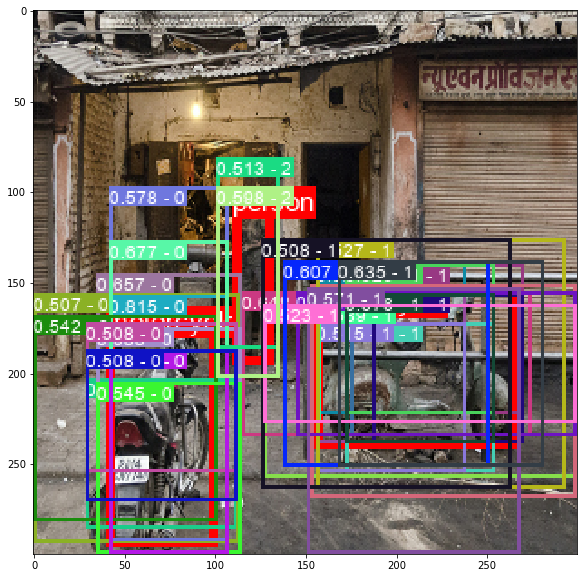

In [104]:
img_size = 300
n_anchors = len(anchors)

for image, bboxes, labels in ds_train.take(1): 
    
    image = Image.fromarray(np.array(image * 255, dtype=np.uint8))
    
    if image is None:
        image = Image.new('RGB', (img_size, img_size))
    
    draw = ImageDraw.Draw(image)

    h, w = image.height, image.width
    
    py_bboxes = []
    
    for bbox, label in zip(bboxes, labels):
        bbox_xyxy = yxyx_to_xyxy(bbox)
        label_text = index_to_label(label)
        py_bboxes.append((float(bbox_xyxy[0]), float(bbox_xyxy[1]), float(bbox_xyxy[2]), float(bbox_xyxy[3])))
        draw_object_bbox_xyxy(draw, bbox_xyxy, h, w, label_text)
    
    negative_anchors = []
    positive_anchors = []
    t1 = time.time()
    for anchor in random.sample(anchors, k=n_anchors):

        best_iou = 0
        best_box_idx = 0
        for box_idx, bbox in enumerate(py_bboxes):
            bbox_xyxy = bbox
            iou = compute_iou(anchor, bbox_xyxy)
            a = anchor
            b = bbox_xyxy
            if iou > best_iou:
                best_iou = iou
                best_box_idx = box_idx
        if best_iou < 0.5:
            negative_anchors.append(anchor)
        else:
            positive_anchors.append((anchor, best_box_idx, best_iou))
    t2 = time.time()
    print("t2 - t1", t2 - t1)
    for anchor, box_idx, iou in positive_anchors:
        draw_anchor(draw, anchor, img_size, label_text="{:.3f} - {}".format(iou, box_idx))

    plt.figure(figsize=figsize)
    plt.imshow(image)